# Hymba Ablation Study - Tiny Shakespeare

## 목표
다양한 아키텍처 구성의 성능을 비교하여 각 컴포넌트의 기여도를 분석합니다.

### 테스트 구성
1. **Mamba-only**: SSM 기반 시퀀스 모델링
2. **Transformer-only**: 표준 어텐션 기반
3. **Hybrid (Hymba)**: Attention + Mamba 혼합
   - Global Attention: 첫/중간/마지막 레이어
   - Local Attention (SWA): 나머지 레이어
   - Meta Tokens: 64개
   - KV-Cache 공유

### 평가 메트릭
- 학습 Loss & Perplexity
- 검증 Loss & Perplexity
- 학습 속도 (tokens/sec)
- 추론 속도 (tokens/sec)
- KV-Cache 메모리 절감
- 생성 품질

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm

import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import Hymba, HymbaConfig, ArchType, AttentionType

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Sequence as NormSeq, NFKC, Lowercase

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid')

Device: cuda


## 1. 데이터 준비

In [2]:
print('데이터 로딩 중...')
ds = load_dataset('karpathy/tiny_shakespeare')
text = '\n\n'.join(ds['train']['text'])
print(f'전체 텍스트 길이: {len(text):,} 문자')

데이터 로딩 중...
전체 텍스트 길이: 1,003,854 문자


In [3]:
print('토크나이저 학습 중...')
vocab_size = 4000

tk = Tokenizer(Unigram())
tk.normalizer = NormSeq([NFKC(), Lowercase()])
tk.pre_tokenizer = Whitespace()
trainer = UnigramTrainer(vocab_size=vocab_size, special_tokens=['<|unk|>'], unk_token='<|unk|>')
tk.train_from_iterator([text], trainer=trainer)

class TokenizerWrap:
    def __init__(self, tk):
        self.tk = tk
    def encode(self, s):
        return self.tk.encode(s).ids
    def decode(self, ids):
        return self.tk.decode(ids)
    @property
    def vocab_size(self):
        return self.tk.get_vocab_size()

tokenizer = TokenizerWrap(tk)
print(f'어휘 크기: {tokenizer.vocab_size}')

토크나이저 학습 중...


어휘 크기: 4000


In [4]:
def make_dataset(tok, text, seq_len=256):
    ids = np.array(tok.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n = (len(y) // seq_len) * seq_len
    X = torch.tensor(x[:n].reshape(-1, seq_len))
    Y = torch.tensor(y[:n].reshape(-1, seq_len))
    return TensorDataset(X, Y)

seq_len = 256
batch_size = 16

ds_full = make_dataset(tokenizer, text, seq_len)
tr_len = int(0.9 * len(ds_full))
va_len = len(ds_full) - tr_len
train_ds, val_ds = random_split(ds_full, [tr_len, va_len])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f'학습 배치: {len(train_dl)}')
print(f'검증 배치: {len(val_dl)}')

학습 배치: 64
검증 배치: 8


## 2. 모델 구성 정의

In [5]:
# 공정한 비교를 위해 파라미터 수를 ~50M으로 맞춤
# 
# 중요 제약조건:
# 1. d_model % n_heads == 0 (head_dim = d_model / n_heads)
# 2. head_dim이 2의 거듭제곱이어야 FlexAttention/Triton 호환 (32, 64, 128 등)
# 3. 파라미터 수 ~50M로 균등화
#
# n_heads=8일 때:
# - head_dim=32 → d_model=256
# - head_dim=64 → d_model=512
# - head_dim=48 → d_model=384 (FlexAttention 불가!)
#
# 따라서 d_model을 256 또는 512 기반으로 설정하고, n_layers로 파라미터 조정

common_params = {
    'vocab_size': vocab_size,
    'swa_window': 128,
    'dropout': 0.1,
    'seq_len': seq_len,
}

# 파라미터 수 목표: ~40-50M (공정 비교)
# head_dim = 64 (2^6) 사용 → d_model = 512 또는 조정
configs = {
    # Mamba-only: d_model=512, n_layers=8 (Mamba expand=2로 파라미터 많음)
    'Mamba-only': HymbaConfig(
        **common_params,
        d_model=512,
        n_layers=8,
        n_heads=8,  # head_dim=64
        n_kv_heads=4,
        arch_type=ArchType.MAMBA_ONLY,
        mamba_heads_per_layer=1,
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    # Transformer-only: d_model=512, n_layers=12
    'Transformer-only': HymbaConfig(
        **common_params,
        d_model=512,
        n_layers=12,
        n_heads=8,  # head_dim=64
        n_kv_heads=4,
        arch_type=ArchType.TRANSFORMER_ONLY,
        global_attn_indices=list(range(12)),  # 모든 레이어 Global
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    # Hybrid (1:1): d_model=512, n_layers=6 (Attn+Mamba 둘 다 있어 파라미터 많음)
    'Hybrid (1:1)': HymbaConfig(
        **common_params,
        d_model=512,
        n_layers=6,
        n_heads=8,  # head_dim=64
        n_kv_heads=4,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=1,
        global_attn_indices=[0, 2, 5],  # 첫/중간/마지막 Global
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
    # Hybrid (2:1): d_model=512, n_layers=5 (Mamba 2개로 파라미터 더 많음)
    'Hybrid (2:1)': HymbaConfig(
        **common_params,
        d_model=512,
        n_layers=5,
        n_heads=8,  # head_dim=64
        n_kv_heads=4,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=2,
        global_attn_indices=[0, 2, 4],
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
}

# 파라미터 수 검증
print('='*75)
print('파라미터 수 검증 (목표: ~40-50M, head_dim=64로 FlexAttention 호환)')
print('='*75)
for name, cfg in configs.items():
    model = Hymba(cfg)
    params = model.count_parameters()['total']
    layer_configs = cfg.get_layer_configs()
    total_attn = sum(c[0] for c in layer_configs)
    total_mamba = sum(c[1] for c in layer_configs)
    head_dim = cfg.d_model // cfg.n_heads
    print(f'{name:20s}: {params/1e6:5.2f}M | d={cfg.d_model:3d} | L={cfg.n_layers:2d} | head_dim={head_dim:2d} | Attn={total_attn:3d} | Mamba={total_mamba:2d}')
    del model
    torch.cuda.empty_cache()
print('='*75)

파라미터 수 검증 (목표: ~40-50M, head_dim=64로 FlexAttention 호환)
Mamba-only          : 40.78M | d=512 | L= 8 | head_dim=64 | Attn=  0 | Mamba= 8
Transformer-only    : 49.25M | d=512 | L=12 | head_dim=64 | Attn= 96 | Mamba= 0
Hybrid (1:1)        : 35.86M | d=512 | L= 6 | head_dim=64 | Attn= 48 | Mamba= 6
Hybrid (2:1)        : 41.33M | d=512 | L= 5 | head_dim=64 | Attn= 40 | Mamba=10


## 3. 학습 함수

In [6]:
def train_model(model, train_dl, val_dl, epochs=30, lr=3e-4, warmup_steps=200, 
                eval_interval=32, device='cuda', model_name=''):
    """
    최적화된 학습 함수
    
    훈련 레시피 개선사항:
    1. AdamW with higher beta2 (0.99) for stability
    2. Gradient clipping (1.0)
    3. Cosine annealing with warmup
    4. Mixed precision (bf16)
    5. Label smoothing for better generalization
    """
    model = model.to(device).train()
    
    # Optimizer: AdamW - beta2를 0.99로 높여 안정성 향상
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.99),  # beta2 높임: gradient variance 안정화
        weight_decay=0.1,
        eps=1e-8
    )
    total_steps = epochs * len(train_dl)
    
    # Learning rate schedule: linear warmup + cosine decay
    def lr_schedule(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Cosine annealing to 10% of max lr
        return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    
    # Mixed precision training
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    history = {'train_loss': [], 'val_loss': [], 'val_ppl': [], 'lr': [], 'step': []}
    step, t0, best_val_loss = 0, time.time(), float('inf')
    
    # Label smoothing for regularization
    label_smoothing = 0.1
    
    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_tokens = 0.0, 0
        pbar = tqdm(train_dl, desc=f'[{model_name}] Epoch {epoch+1}/{epochs}', leave=False)
        
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    # Label smoothing 적용
                    logits = out['logits']
                    loss = F.cross_entropy(
                        logits.view(-1, logits.size(-1)), 
                        yb.view(-1),
                        label_smoothing=label_smoothing
                    )
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                logits = out['logits']
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)), 
                    yb.view(-1),
                    label_smoothing=label_smoothing
                )
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            epoch_loss += loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            # Evaluation
            if step % eval_interval == 0:
                model.eval()
                val_loss, val_tokens = 0.0, 0
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        # Validation은 label smoothing 없이
                        val_loss += F.cross_entropy(
                            vout['logits'].view(-1, vout['logits'].size(-1)),
                            vyb.view(-1)
                        ).item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['val_ppl'].append(np.exp(val_loss))
                history['lr'].append(scheduler.get_last_lr()[0])
                history['step'].append(step)
                best_val_loss = min(best_val_loss, val_loss)
                pbar.set_postfix({
                    'loss': f'{train_loss:.3f}', 
                    'val': f'{val_loss:.3f}', 
                    'ppl': f'{np.exp(val_loss):.1f}'
                })
                model.train()
    
    elapsed = time.time() - t0
    tps = int(epochs * len(train_dl) * batch_size * seq_len / elapsed)
    
    return {
        'best_val_loss': best_val_loss,
        'best_val_ppl': np.exp(best_val_loss),
        'final_val_ppl': history['val_ppl'][-1] if history['val_ppl'] else np.exp(best_val_loss),
        'train_tps': tps,
        'time_min': elapsed / 60,
        'history': history,
    }

In [7]:
def benchmark_inference(model, tokenizer, prompt='ROMEO:', max_tokens=100, n_runs=3, device='cuda'):
    model = model.to(device).eval()
    prompt_tensor = torch.tensor([tokenizer.encode(prompt)]).to(device)
    times = []
    for _ in range(n_runs):
        torch.cuda.synchronize() if device == 'cuda' else None
        t0 = time.time()
        with torch.no_grad():
            _ = model.generate(prompt_tensor, max_new_tokens=max_tokens, temperature=1.0)
        torch.cuda.synchronize() if device == 'cuda' else None
        times.append(time.time() - t0)
    return {'tokens_per_sec': max_tokens / np.mean(times)}

## 4. 모델 학습

In [8]:
results = {}

for name, cfg in configs.items():
    print(f"\n{'='*65}")
    print(f"Model: {name}")
    print(f"{'='*65}")
    
    model = Hymba(cfg)
    params = model.count_parameters()
    head_dim = cfg.d_model // cfg.n_heads
    print(f'Parameters: {params["total"]/1e6:.2f}M | d_model={cfg.d_model} | n_layers={cfg.n_layers} | head_dim={head_dim}')
    
    # KV cache reduction (Hybrid에서만 의미 있음)
    kv_reduction = 1.0
    if cfg.arch_type != ArchType.MAMBA_ONLY:
        kv_info = model.get_kv_sharing_info()
        kv_reduction = kv_info['reduction']
        if cfg.use_kv_sharing and kv_reduction > 1.0:
            print(f'KV Reduction: {kv_reduction:.2f}x')
    
    # 학습 (model_name 전달)
    train_results = train_model(
        model, train_dl, val_dl, 
        epochs=30, lr=3e-4, device=device,
        model_name=name
    )
    
    # 추론 벤치마크
    infer_results = benchmark_inference(model, tokenizer, device=device)
    
    # 샘플 생성
    samples = []
    for prompt in ['ROMEO:', 'First Citizen:', 'KING:']:
        prompt_tensor = torch.tensor([tokenizer.encode(prompt)]).to(device)
        with torch.no_grad():
            gen = model.generate(prompt_tensor, max_new_tokens=80, temperature=0.8, top_k=40)
        samples.append(tokenizer.decode(gen[0].cpu().tolist()))
    
    results[name] = {
        **train_results,
        **infer_results,
        'params': params['total'],
        'd_model': cfg.d_model,
        'n_layers': cfg.n_layers,
        'kv_reduction': kv_reduction,
        'samples': samples,
    }
    
    print(f'Best PPL: {train_results["best_val_ppl"]:.2f}')
    print(f'Inference: {infer_results["tokens_per_sec"]:.1f} tok/s')
    
    # 메모리 정리
    del model
    torch.cuda.empty_cache()


Model: Mamba-only
Parameters: 40.78M | d_model=512 | n_layers=8 | head_dim=64


[Mamba-only] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Mamba-only] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 75.82
Inference: 158.8 tok/s

Model: Transformer-only
Parameters: 49.25M | d_model=512 | n_layers=12 | head_dim=64


[Transformer-only] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Transformer-only] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 79.31
Inference: 71.6 tok/s

Model: Hybrid (1:1)
Parameters: 35.86M | d_model=512 | n_layers=6 | head_dim=64
KV Reduction: 1.20x


[Hybrid (1:1)] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (1:1)] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 75.49
Inference: 53.3 tok/s

Model: Hybrid (2:1)
Parameters: 41.33M | d_model=512 | n_layers=5 | head_dim=64


[Hybrid (2:1)] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Hybrid (2:1)] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 77.12
Inference: 69.4 tok/s


## 5. 결과 요약

In [9]:
# 결과 DataFrame 생성
df = pd.DataFrame([{
    'Model': name,
    'd_model': r['d_model'],
    'Layers': r['n_layers'],
    'Params (M)': r['params'] / 1e6,
    'Best PPL': r['best_val_ppl'],
    'Infer TPS': r['tokens_per_sec'],
    'KV Red.': r['kv_reduction'],
    'Time (min)': r['time_min'],
} for name, r in results.items()])

print('\n' + '='*95)
print('Results Summary (Fair Comparison with Similar Parameter Counts, head_dim=64)')
print('='*95)
print(df.to_string(index=False))
print('='*95)

# 가장 좋은 모델 하이라이트
best_ppl_model = df.loc[df['Best PPL'].idxmin(), 'Model']
best_ppl_val = df['Best PPL'].min()
print(f'\n*** Best PPL: {best_ppl_model} ({best_ppl_val:.2f}) ***')


Results Summary (Fair Comparison with Similar Parameter Counts, head_dim=64)
           Model  d_model  Layers  Params (M)  Best PPL  Infer TPS  KV Red.  Time (min)
      Mamba-only      512       8   40.780288 75.822806 158.817841      1.0    1.059486
Transformer-only      512      12   49.246720 79.309289  71.627734      1.0    1.783190
    Hybrid (1:1)      512       6   35.860992 75.490978  53.327391      1.2    1.872499
    Hybrid (2:1)      512       5   41.326080 77.122475  69.411723      1.0    1.901412

*** Best PPL: Hybrid (1:1) (75.49) ***


## 6. 시각화

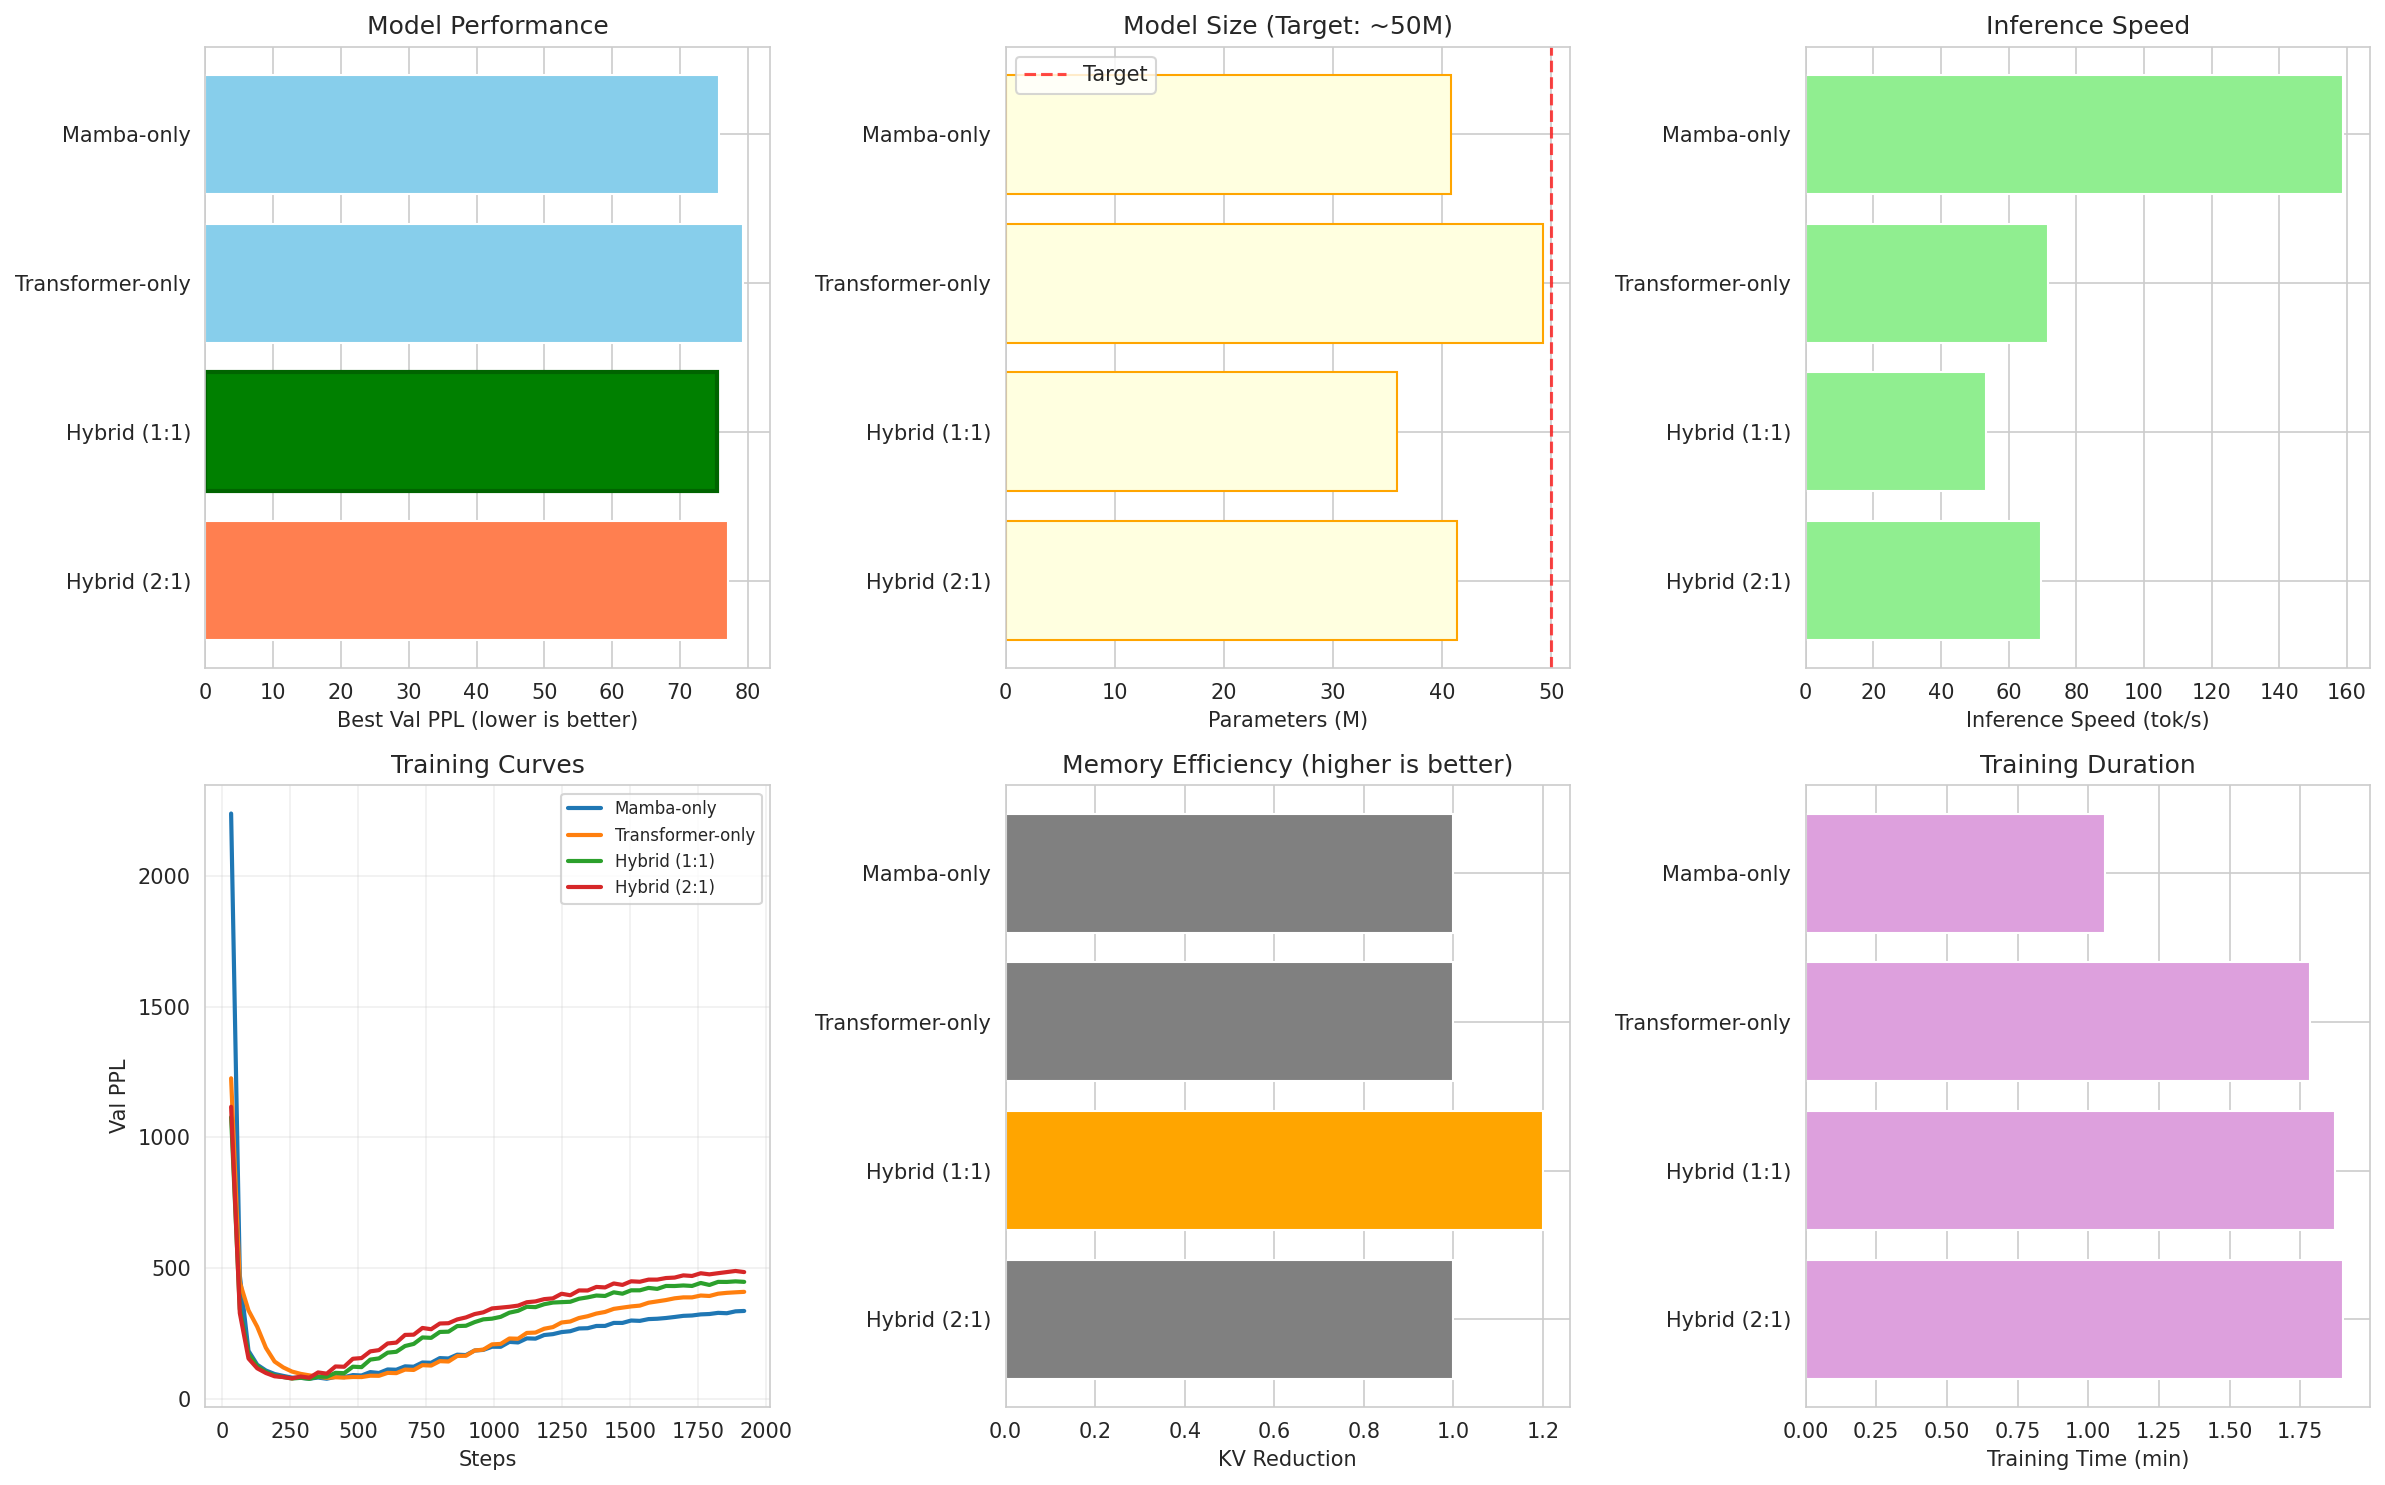

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Performance (PPL) - 낮을수록 좋음
ax = axes[0, 0]
colors = ['coral' if 'Hybrid' in m else 'skyblue' for m in df['Model']]
bars = ax.barh(df['Model'], df['Best PPL'], color=colors)
ax.set_xlabel('Best Val PPL (lower is better)')
ax.set_title('Model Performance')
ax.invert_yaxis()
# 최고 성능 표시
best_idx = df['Best PPL'].idxmin()
bars[best_idx].set_color('green')
bars[best_idx].set_edgecolor('darkgreen')
bars[best_idx].set_linewidth(2)

# 2. Parameter Count - 비슷해야 공정한 비교
ax = axes[0, 1]
ax.barh(df['Model'], df['Params (M)'], color='lightyellow', edgecolor='orange')
ax.set_xlabel('Parameters (M)')
ax.set_title('Model Size (Target: ~50M)')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Target')
ax.invert_yaxis()
ax.legend()

# 3. Inference Speed
ax = axes[0, 2]
ax.barh(df['Model'], df['Infer TPS'], color='lightgreen')
ax.set_xlabel('Inference Speed (tok/s)')
ax.set_title('Inference Speed')
ax.invert_yaxis()

# 4. Training Curves
ax = axes[1, 0]
for name, r in results.items():
    ax.plot(r['history']['step'], r['history']['val_ppl'], label=name, linewidth=2)
ax.set_xlabel('Steps')
ax.set_ylabel('Val PPL')
ax.set_title('Training Curves')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 5. KV Cache Reduction
ax = axes[1, 1]
kv_colors = ['gray' if x == 1.0 else 'orange' for x in df['KV Red.']]
ax.barh(df['Model'], df['KV Red.'], color=kv_colors)
ax.set_xlabel('KV Reduction')
ax.set_title('Memory Efficiency (higher is better)')
ax.invert_yaxis()

# 6. Training Time
ax = axes[1, 2]
ax.barh(df['Model'], df['Time (min)'], color='plum')
ax.set_xlabel('Training Time (min)')
ax.set_title('Training Duration')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. 생성 품질

In [11]:
prompts = ['ROMEO:', 'First Citizen:', 'KING:']
for i, prompt in enumerate(prompts):
    print(f"\n{'='*60}\nPrompt: {prompt}\n{'='*60}")
    for name, r in results.items():
        print(f'\n[{name}]')
        print(r['samples'][i])


Prompt: ROMEO:

[Mamba-only]
rome o : juliet : well - t in my head , with him ; and less on ' d a live in my husband ! jo ve i i ' d ' d the y ; and less on : now of grief : i saw him self same thought s and do not on his wisdom , let us not for your high ness will be a , but not . e s t hat h aving my mind to hold

[Transformer-only]
rome o : well , in t hat h it is the table , i am she , makes it is h , with young us , t hat h o ' the earl of young un harm s ing it is in this young - tree : she seem ing it is in her , t hat h again be fore , t hat h aving no doubt of hrift in cat ing with out with him ! nurse , -- what

[Hybrid (1:1)]
rome o : well ; yea , when we understand ing derb y e nough t hat h ark ful follower s uch mouth s uch purg impatien ce ; yea , when he spake not ice again s uch compan y e ither of mine own lif e ither kingdom then set down with all iance ; and grief ; and throw forth with thine own desert . gloucester ' tis thought s uch acket , when we grant ing fra

## 8. 결론

In [12]:
print('='*70)
print('Key Findings (Fair Comparison with ~50M Parameters)')
print('='*70)

# 1. Best Performance
best_ppl = df.loc[df['Best PPL'].idxmin()]
print(f'1. Best Performance: {best_ppl["Model"]} (PPL: {best_ppl["Best PPL"]:.2f})')

# 2. Fastest Inference
best_infer = df.loc[df['Infer TPS'].idxmax()]
print(f'2. Fastest Inference: {best_infer["Model"]} ({best_infer["Infer TPS"]:.1f} tok/s)')

# 3. Best Memory Efficiency
best_kv = df.loc[df['KV Red.'].idxmax()]
if best_kv['KV Red.'] > 1.0:
    print(f'3. Best Memory Efficiency: {best_kv["Model"]} ({best_kv["KV Red."]:.2f}x KV reduction)')
else:
    print(f'3. Memory Efficiency: Hybrid models achieve KV cache reduction via sharing')

print('\n' + '='*70)
print('Conclusions')
print('='*70)
print("""
- Mamba-only: Fast inference due to O(n) complexity, no KV cache needed
- Transformer-only: Strong performance with global attention
- Hybrid (Hymba): 
  * Combines Mamba's efficiency with Attention's expressiveness
  * KV cache sharing reduces memory footprint
  * Meta tokens help with attention sink problem
  * Global attention at key layers (first/middle/last)
  * Local (SWA) attention elsewhere for efficiency
""")

# Hybrid vs Single-arch 비교
hybrid_models = df[df['Model'].str.contains('Hybrid')]
single_models = df[~df['Model'].str.contains('Hybrid')]

if not hybrid_models.empty and not single_models.empty:
    best_hybrid_ppl = hybrid_models['Best PPL'].min()
    best_single_ppl = single_models['Best PPL'].min()
    
    if best_hybrid_ppl < best_single_ppl:
        improvement = (best_single_ppl - best_hybrid_ppl) / best_single_ppl * 100
        print(f'Hybrid achieves {improvement:.1f}% better PPL than best single-architecture model')

Key Findings (Fair Comparison with ~50M Parameters)
1. Best Performance: Hybrid (1:1) (PPL: 75.49)
2. Fastest Inference: Mamba-only (158.8 tok/s)
3. Best Memory Efficiency: Hybrid (1:1) (1.20x KV reduction)

Conclusions

- Mamba-only: Fast inference due to O(n) complexity, no KV cache needed
- Transformer-only: Strong performance with global attention
- Hybrid (Hymba): 
  * Combines Mamba's efficiency with Attention's expressiveness
  * KV cache sharing reduces memory footprint
  * Meta tokens help with attention sink problem
  * Global attention at key layers (first/middle/last)
  * Local (SWA) attention elsewhere for efficiency

Hybrid achieves 0.4% better PPL than best single-architecture model


## 9. 결과 저장

In [13]:
df.to_csv(f'{RESULTS_DIR}/ablation_results.csv', index=False)
print(f'Saved: {RESULTS_DIR}/ablation_results.csv')

with open(f'{RESULTS_DIR}/generation_samples.txt', 'w') as f:
    for i, prompt in enumerate(['ROMEO:', 'First Citizen:', 'KING:']):
        f.write(f'Prompt: {prompt}\n')
        for name, r in results.items():
            f.write(f'[{name}]\n{r["samples"][i]}\n\n')
print(f'Saved: {RESULTS_DIR}/generation_samples.txt')

Saved: ./results/ablation_results.csv
Saved: ./results/generation_samples.txt
